In [37]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import math
from PIL import Image, ImageFilter
import cv2 as cv
import torch
import sklearn
from sklearn import preprocessing
from collections import Counter
from sklearn.model_selection import train_test_split
from mtcnn.mtcnn import MTCNN
from skimage.util import random_noise
from hashlib import sha1

In [32]:
def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

def alignment_procedure(img, left_eye, right_eye, nose):

    #this function aligns given face in img based on left and right eye coordinates

    #left eye is the eye appearing on the left (right eye of the person)
    #left top point is (0, 0)

    left_eye_x, left_eye_y = left_eye
    right_eye_x, right_eye_y = right_eye

    #-----------------------
    #decide the image is inverse

    center_eyes = (int((left_eye_x + right_eye_x) / 2), int((left_eye_y + right_eye_y) / 2))
    
    if False:

        img = cv2.circle(img, (int(left_eye[0]), int(left_eye[1])), 2, (0, 255, 255), 2)
        img = cv2.circle(img, (int(right_eye[0]), int(right_eye[1])), 2, (255, 0, 0), 2)
        img = cv2.circle(img, center_eyes, 2, (0, 0, 255), 2)
        img = cv2.circle(img, (int(nose[0]), int(nose[1])), 2, (255, 255, 255), 2)

    #-----------------------
    #find rotation direction

    if left_eye_y > right_eye_y:
        point_3rd = (right_eye_x, left_eye_y)
        direction = -1 #rotate same direction to clock
    else:
        point_3rd = (left_eye_x, right_eye_y)
        direction = 1 #rotate inverse direction of clock

    #-----------------------
    #find length of triangle edges

    a = findEuclideanDistance(np.array(left_eye), np.array(point_3rd))
    b = findEuclideanDistance(np.array(right_eye), np.array(point_3rd))
    c = findEuclideanDistance(np.array(right_eye), np.array(left_eye))

    #-----------------------

    #apply cosine rule

    if b != 0 and c != 0: #this multiplication causes division by zero in cos_a calculation

        cos_a = (b*b + c*c - a*a)/(2*b*c)
        
        #PR15: While mathematically cos_a must be within the closed range [-1.0, 1.0], floating point errors would produce cases violating this
        #In fact, we did come across a case where cos_a took the value 1.0000000169176173, which lead to a NaN from the following np.arccos step
        cos_a = min(1.0, max(-1.0, cos_a))
        
        
        angle = np.arccos(cos_a) #angle in radian
        angle = (angle * 180) / math.pi #radian to degree

        #-----------------------
        #rotate base image

        if direction == -1:
            angle = 90 - angle

        img = Image.fromarray(img)
        img = np.array(img.rotate(direction * angle))

        if center_eyes[1] > nose[1]:
            img = Image.fromarray(img)
            img = np.array(img.rotate(180))

    #-----------------------

    return img #return img anyway

def align_faces(data_list, lbl_list):

    detector = MTCNN()
    data_list_cp = data_list.copy()

    faces = []
    aligned_lbls = []
    non_aligned_lbls = []
   
    for i, each in enumerate(data_list):
        faces = detector.detect_faces(each)
        if len(faces) == 1  :
        
            aligned_img = alignment_procedure(data_list[i], faces[0]["keypoints"]["left_eye"], faces[0]["keypoints"]["right_eye"], faces[0]["keypoints"]["nose"])
            data_list_cp[i] = aligned_img
            
            aligned_lbls.append(lbl_list[i])
            
            
        else:
            non_aligned_lbls.append(lbl_list[i])
            
            
    return data_list_cp, Counter(aligned_lbls), Counter(non_aligned_lbls)

In [33]:
def flip(img_list):
    
    flippedImages = []
    for each in img_list:
        flipped = np.fliplr(each)
        flippedImages.append(flipped)
        
    return flippedImages

In [34]:
def increase_brightness(img_list, value=25):
    brightImages = []
    for each in img_list:
        hsv = cv.cvtColor(each, cv.COLOR_BGR2HSV)
        h, s, v = cv.split(hsv)

        lim = 255 - value
        v[v > lim] = 255
        v[v <= lim] += value

        final_hsv = cv.merge((h, s, v))
        img = cv.cvtColor(final_hsv, cv.COLOR_HSV2BGR)
        brightImages.append(img)
    return brightImages

In [35]:
def normalize_faces(data_list):
    
    data_list_new = []
    img = None
    
    for each in data_list:
        
        img = each/255.0
        
        data_list_new.append(img)
    
        
    return data_list_new

In [7]:
#LOADING DATASET AND LABELS 
root_dir = 'trainingDataset/'
class_folders = [directory for directory in os.listdir(root_dir) if os.path.isdir(root_dir+directory)]
print('Labels are ' + str(class_folders))

data_set1 = []
original_label_set1 = []

temp_data = []
for each in class_folders:
    temp_data =  [cv.cvtColor(cv.imread((root_dir+each+"/"+name)), cv.COLOR_BGR2RGB) for name in os.listdir((root_dir+each+"/")) if name.endswith(".jpg")]
    data_set1 += temp_data
    original_label_set1 += [each]*len(temp_data)
    
print('There are '+str(len(data_set1))+' samples.')
print('There are '+str(len(original_label_set1))+' labels.')

Labels are ['ANGER', 'DISGUST', 'FEAR', 'HAPPINESS', 'SADNESS', 'SURPRISE']
There are 43435 samples.
There are 43435 labels.


In [8]:
#DETECT AND REMOVE DUPLICATES
hash_table = {}
dup_id_list = []
for i, each_data in enumerate(data_set1):
    hash_num = sha1(each_data).hexdigest()
    if hash_num in hash_table:
        dup_id_list += [i]
        
    else:
        hash_table[hash_num] = i
        
data_no_duplicates1 = data_set1.copy()
label_no_duplicates1 = original_label_set1.copy()

dup_id_list.reverse()

for each in dup_id_list:
    del data_no_duplicates1[each]
    del label_no_duplicates1[each]

print('There are '+str(len(data_no_duplicates1))+' samples after duplicate removal.')
print('There are '+str(len(label_no_duplicates1))+' labels after duplicate removal.')

There are 43239 samples after duplicate removal.
There are 43239 labels after duplicate removal.


In [9]:
#Label encoding
label_enc = preprocessing.LabelEncoder()
label_enc.fit(label_no_duplicates1)  
label_uniq_classes = label_enc.classes_
label_encoded_label_set1 = label_enc.transform(label_no_duplicates1)

Training set class distribution =  Counter({'SADNESS': 13040, 'HAPPINESS': 9113, 'ANGER': 8228, 'SURPRISE': 7418, 'FEAR': 2985, 'DISGUST': 2651})


Text(0.5, 1.0, 'Training set class distribution')

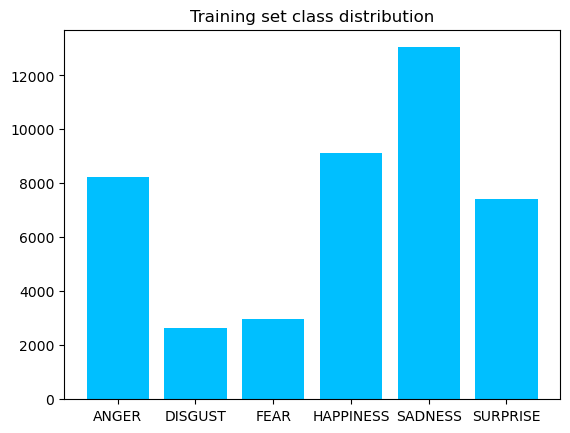

In [11]:
class_distribution1 = Counter(original_label_set1)
print("Training set class distribution = ", class_distribution1)
plt.bar(class_distribution1.keys(), class_distribution1.values(), align='center', color='deepskyblue')

plt.title("Training set class distribution")

In [39]:
#the training data is split into training, testing, validation sets
x_train, x_test, y_train, y_test = train_test_split(data_no_duplicates, label_encoded_label_set, test_size=0.3, random_state=0, stratify=label_encoded_label_set, shuffle=True)

In [18]:
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.333333333333, random_state=0, stratify=y_test, shuffle=True)

In [23]:
%%time
x_train_aligned, train_aligned_stat, train_non_aligned_stat = align_faces(x_train, y_train)

CPU times: total: 3h 26min 12s
Wall time: 2h 51min 11s


In [24]:
%%time
x_val_aligned, val_aligned_stat, val_non_aligned_stat = align_faces(x_val, y_val)

CPU times: total: 1h 13min 23s
Wall time: 1h 1min 40s


In [25]:
%%time
x_test_aligned, test_aligned_stat, test_non_aligned_stat = align_faces(x_test, y_test)

CPU times: total: 39min 37s
Wall time: 33min 47s


In [36]:
#as the alignment process took multiple hours, the aligned output is saved in this cell so it
#can be loaded later without the need to run the alignment process again

with open('x_train_aligned.npy', 'wb') as f:
    np.save(f, np.array(x_train_aligned))
with open('y_train_aligned.npy', 'wb') as f:
    np.save(f, y_train.astype(int))
    
with open('x_val_aligned.npy', 'wb') as f:
    np.save(f, np.array(x_val_aligned))
with open('y_val_aligned.npy', 'wb') as f:
    np.save(f, y_val.astype(int))
    
with open('x_test_aligned.npy', 'wb') as f:
    np.save(f, np.array(x_test_aligned))
with open('y_test_aligned.npy', 'wb') as f:
    np.save(f, y_test.astype(int))

In [7]:
#here is how to load the aligned data after it has been saved
x_train_aligned = (np.load('x_train_aligned.npy').astype('uint8'))
x_val_aligned = (np.load('x_val_aligned.npy').astype('uint8'))
x_test_aligned = (np.load('x_test_aligned.npy').astype('uint8'))

y_train = np.load('y_train_aligned.npy')
y_val = np.load('y_val_aligned.npy')
y_test = np.load('y_test_aligned.npy')

In [8]:
#here the data is merged again, so there is no need to run the alignment cells again after data augmentation
final_x = np.concatenate((x_train_aligned, x_val_aligned, x_test_aligned))
final_y = np.concatenate((y_train, y_val, y_test), axis=None)

In [9]:
#For Anger, class label = 0
#Augmenting anger class with 4812 random horizontal flips, resulting in 13040 total samples

b = [i for i, x in enumerate(final_y) if x == 0]
print(len(b))
c = 4812
print("Anger horizontally flipped images amount = ",c)
np.random.seed(0)
aug_img_indexes = np.random.choice(b,c)
aug_img_indexes

aug_images = []
for i in aug_img_indexes:
    aug_images.append(final_x[i])
    
anger_flipped = flip(aug_images)

anger_augmented_labels = np.zeros(len(anger_flipped))

8228
Anger horizontally flipped images amount =  4812


In [10]:
#For Disgust, class label = 1
#Augmenting disgust class with 2458 horizontal flips, resulting in 4916 total samples

b = [i for i, x in enumerate(final_y) if x == 1]
print("Disgust samples amount = ",len(b))

aug_images = []
for i in b:
    aug_images.append(final_x[i])
    
disgust_flipped = flip(aug_images)

#Augmenting disgust class with 2458 10% higher brightness images, resulting in 7374 total samples
disgust_10bright = increase_brightness(aug_images)

#Augmenting disgust class with 2458 10% higher brightness horizontally flipped images, resulting in 9832 total samples
disgust_flipped_bright = increase_brightness(disgust_flipped)

#Augmenting disgust class with 2458 5% increased brightness images, resulting in 12290 total samples
disgust_5bright = increase_brightness(aug_images, value=12)

#Augmenting disgust class with 750 5% increased brightness horizontally flipped images, resulting in 13040 total samples
a= disgust_flipped[-750:]  
disgust_flipped_5bright = increase_brightness(a, value=12)

disgust_augmented_imgs = disgust_flipped + disgust_10bright + disgust_flipped_bright + disgust_5bright + disgust_flipped_5bright
disgust_augmented_lbs = np.ones(len(disgust_augmented_imgs))

print("Disgust augmented images amount = ",len(disgust_augmented_imgs))

Disgust samples amount =  2458
Disgust augmented images amount =  10582


In [11]:
#For Fear, class label = 2
#Augmenting fear class with 2983 horizontal flips, resulting in 5966 total samples

b = [i for i, x in enumerate(final_y) if x == 2]
print("Fear samples amount = ",len(b))

aug_images = []
for i in b:
    aug_images.append(final_x[i])
    
fear_flipped = flip(aug_images)

#Augmenting fear class with 2983 10% higher brightness images, resulting in 8949 total samples

fear_10bright = increase_brightness(aug_images)

#Augmenting disgust class with 2983 10% higher brightness horizontally flipped images, resulting in 11932 total samples
fear_flipped_bright = increase_brightness(fear_flipped)


#Augmenting disgust class with 1108 5% increased brightness images, resulting in 13040 total samples
a= aug_images[-1108:]  
fear_5bright = increase_brightness(a, value=12)

fear_augmented_imgs = fear_flipped + fear_10bright + fear_flipped_bright + fear_5bright
fear_augmented_lbs = np.ones(len(fear_augmented_imgs))*2

print("Fear augmented images amount = ",len(fear_augmented_imgs))

Fear samples amount =  2983
Fear augmented images amount =  10057


In [12]:
#For Happiness, class label = 3
#Augmenting happiness class with 3927 random horizontal flips, resulting in 13040 total samples

b = [i for i, x in enumerate(final_y) if x == 3]
print(len(b))
c = 3927
print("Happiness horizontally flipped images amount = ",c)
np.random.seed(0)
aug_img_indexes = np.random.choice(b,c)
aug_img_indexes

aug_images = []
for i in aug_img_indexes:
    aug_images.append(final_x[i])
    
happiness_flipped = flip(aug_images)
happiness_augmented_labels = np.ones(len(happiness_flipped))*3

9113
Happiness horizontally flipped images amount =  3927


In [13]:
#For Surprise, class label = 5
#Augmenting happiness class with 5623 random horizontal flips, resulting in 13040 total samples

b = [i for i, x in enumerate(final_y) if x == 5]
print(len(b))
c = 5623
print("Surprise horizontally flipped images amount = ",c)
np.random.seed(0)
aug_img_indexes = np.random.choice(b,c)
aug_img_indexes

aug_images = []
for i in aug_img_indexes:
    aug_images.append(final_x[i])
    
surprise_flipped = flip(aug_images)
surprise_augmented_labels = np.ones(len(surprise_flipped))*5

7417
Surprise horizontally flipped images amount =  5623


In [14]:
balanced_x = np.concatenate((final_x, np.array(anger_flipped), np.array(disgust_augmented_imgs), np.array(fear_augmented_imgs), np.array(happiness_flipped), np.array(surprise_flipped)))

In [15]:
balanced_y = np.concatenate((final_y, anger_augmented_labels, disgust_augmented_lbs, fear_augmented_lbs, happiness_augmented_labels,  surprise_augmented_labels )) 

In [16]:
#here we can see the now balanced data classes
Counter(balanced_y)

Counter({5.0: 13040,
         4.0: 13040,
         3.0: 13040,
         0.0: 13040,
         2.0: 13040,
         1.0: 13040})

In [17]:
#Normalising images to values ranging from 0 to 1
x_normalized = normalize_faces(balanced_x)

In [19]:
#Here the now augmented, balanced, aligned, normalised training data is split again.
#The repetition of this step could have been avoided by aligning the faces without splitting the data before
#However the problem has been addressed in this way due to time limitations, as the aligning process takes up to 6 hours
x_train, x_test, y_train, y_test = train_test_split(x_normalized, balanced_y, test_size=0.3, random_state=0, stratify=balanced_y, shuffle=True)

In [20]:
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.333333333333, random_state=0, stratify=y_test, shuffle=True)

In [25]:
#saving pre processed training data

with open('fin_train_x.npy', 'wb') as f:
    np.save(f, np.array(x_train, dtype='float16'))
with open('fin_train_y.npy', 'wb') as f:
    np.save(f, y_train.astype(int))
    
with open('fin_val_x.npy', 'wb') as f:
    np.save(f, np.array(x_val, dtype='float16'))
with open('fin_val_y.npy', 'wb') as f:
    np.save(f, y_val.astype(int))
    
with open('fin_test_x.npy', 'wb') as f:
    np.save(f, np.array(x_test, dtype='float16'))
with open('fin_test_y.npy', 'wb') as f:
    np.save(f, y_test.astype(int))

In [ ]:
#In the following cells we will augment the previous training data with some blurred images
#Creating a new training set for the second model of the study

In [21]:
#Augmented model dataset 
#For Anger, class label = 0
#Augmenting anger class with 1000 low blur, 1000 medium and 1000 high blur samples

b = [i for i, x in enumerate(balanced_y) if x == 0]
print(len(b))
c = 1000
print("Anger horizontally flipped images amount = ",c*3)
np.random.seed(1)
low_blur_img_index = np.random.choice(b,c)

np.random.seed(2)
med_blur_img_index = np.random.choice(b,c)

np.random.seed(3)
high_blur_img_index = np.random.choice(b,c)

ang_aug_blur_imgs = []

for i in low_blur_img_index:
    im = Image.fromarray(np.uint8(balanced_x[i]))
    blur = im.filter(ImageFilter.BoxBlur(2))
    blurImage = np.array(blur, dtype='uint8')
    ang_aug_blur_imgs.append(blurImage)
    
for i in med_blur_img_index:
    im = Image.fromarray(np.uint8(balanced_x[i]))
    blur = im.filter(ImageFilter.BoxBlur(4))
    blurImage = np.array(blur, dtype='uint8')
    ang_aug_blur_imgs.append(blurImage)
    
for i in high_blur_img_index:
    im = Image.fromarray(np.uint8(balanced_x[i]))
    blur = im.filter(ImageFilter.BoxBlur(8))
    blurImage = np.array(blur, dtype='uint8')
    ang_aug_blur_imgs.append(blurImage)
    
ang_aug_blur_lbs = np.zeros(len(ang_aug_blur_imgs))
print(len(ang_aug_blur_imgs))

13040
Anger horizontally flipped images amount =  3000
3000


In [22]:
#For Disgust, class label = 1
#Augmenting disgust class with 1000 low blur, 1000 medium and 1000 high blur samples

b = [i for i, x in enumerate(balanced_y) if x == 1]
print(len(b))
c = 1000
print("Disgust horizontally flipped images amount = ",c*3)
np.random.seed(1)
low_blur_img_index = np.random.choice(b,c)

np.random.seed(2)
med_blur_img_index = np.random.choice(b,c)

np.random.seed(3)
high_blur_img_index = np.random.choice(b,c)

disg_aug_blur_imgs = []

for i in low_blur_img_index:
    im = Image.fromarray(np.uint8(balanced_x[i]))
    blur = im.filter(ImageFilter.BoxBlur(2))
    blurImage = np.array(blur, dtype='uint8')
    disg_aug_blur_imgs.append(blurImage)
    
for i in med_blur_img_index:
    im = Image.fromarray(np.uint8(balanced_x[i]))
    blur = im.filter(ImageFilter.BoxBlur(4))
    blurImage = np.array(blur, dtype='uint8')
    disg_aug_blur_imgs.append(blurImage)
    
for i in high_blur_img_index:
    im = Image.fromarray(np.uint8(balanced_x[i]))
    blur = im.filter(ImageFilter.BoxBlur(8))
    blurImage = np.array(blur, dtype='uint8')
    disg_aug_blur_imgs.append(blurImage)
    
disg_aug_blur_lbs = np.ones(len(disg_aug_blur_imgs))
print(len(disg_aug_blur_imgs))

13040
Disgust horizontally flipped images amount =  3000
3000


In [23]:
#For Fear, class label = 2
#Augmenting fear class with 1000 low blur, 1000 medium and 1000 high blur samples

b = [i for i, x in enumerate(balanced_y) if x == 2]
print(len(b))
c = 1000
print("Fear horizontally flipped images amount = ",c*3)
np.random.seed(1)
low_blur_img_index = np.random.choice(b,c)

np.random.seed(2)
med_blur_img_index = np.random.choice(b,c)

np.random.seed(3)
high_blur_img_index = np.random.choice(b,c)

fear_aug_blur_imgs = []

for i in low_blur_img_index:
    im = Image.fromarray(np.uint8(balanced_x[i]))
    blur = im.filter(ImageFilter.BoxBlur(2))
    blurImage = np.array(blur, dtype='uint8')
    fear_aug_blur_imgs.append(blurImage)
    
for i in med_blur_img_index:
    im = Image.fromarray(np.uint8(balanced_x[i]))
    blur = im.filter(ImageFilter.BoxBlur(4))
    blurImage = np.array(blur, dtype='uint8')
    fear_aug_blur_imgs.append(blurImage)
    
for i in high_blur_img_index:
    im = Image.fromarray(np.uint8(balanced_x[i]))
    blur = im.filter(ImageFilter.BoxBlur(8))
    blurImage = np.array(blur, dtype='uint8')
    fear_aug_blur_imgs.append(blurImage)
    
fear_aug_blur_lbs = np.ones(len(fear_aug_blur_imgs))*2
print(len(disg_aug_blur_imgs))

13040
Fear horizontally flipped images amount =  3000
3000


In [24]:
#For Happiness, class label = 3
#Augmenting happiness class with 1000 low blur, 1000 medium and 1000 high blur samples

b = [i for i, x in enumerate(balanced_y) if x == 3]
print(len(b))
c = 1000
print("Happiness horizontally flipped images amount = ",c*3)
np.random.seed(1)
low_blur_img_index = np.random.choice(b,c)

np.random.seed(2)
med_blur_img_index = np.random.choice(b,c)

np.random.seed(3)
high_blur_img_index = np.random.choice(b,c)

hap_aug_blur_imgs = []

for i in low_blur_img_index:
    im = Image.fromarray(np.uint8(balanced_x[i]))
    blur = im.filter(ImageFilter.BoxBlur(2))
    blurImage = np.array(blur, dtype='uint8')
    hap_aug_blur_imgs.append(blurImage)
    
for i in med_blur_img_index:
    im = Image.fromarray(np.uint8(balanced_x[i]))
    blur = im.filter(ImageFilter.BoxBlur(4))
    blurImage = np.array(blur, dtype='uint8')
    hap_aug_blur_imgs.append(blurImage)
    
for i in high_blur_img_index:
    im = Image.fromarray(np.uint8(balanced_x[i]))
    blur = im.filter(ImageFilter.BoxBlur(8))
    blurImage = np.array(blur, dtype='uint8')
    hap_aug_blur_imgs.append(blurImage)
    
hap_aug_blur_lbs = np.ones(len(hap_aug_blur_imgs))*3
print(len(hap_aug_blur_imgs))

13040
Happiness horizontally flipped images amount =  3000
3000


In [25]:
#For Sadness, class label = 4
#Augmenting sadness class with 1000 low blur, 1000 medium and 1000 high blur samples

b = [i for i, x in enumerate(balanced_y) if x == 4]
print(len(b))
c = 1000
print("Sadness horizontally flipped images amount = ",c*3)
np.random.seed(1)
low_blur_img_index = np.random.choice(b,c)

np.random.seed(2)
med_blur_img_index = np.random.choice(b,c)

np.random.seed(3)
high_blur_img_index = np.random.choice(b,c)

sad_aug_blur_imgs = []

for i in low_blur_img_index:
    im = Image.fromarray(np.uint8(balanced_x[i]))
    blur = im.filter(ImageFilter.BoxBlur(2))
    blurImage = np.array(blur, dtype='uint8')
    sad_aug_blur_imgs.append(blurImage)
    
for i in med_blur_img_index:
    im = Image.fromarray(np.uint8(balanced_x[i]))
    blur = im.filter(ImageFilter.BoxBlur(4))
    blurImage = np.array(blur, dtype='uint8')
    sad_aug_blur_imgs.append(blurImage)
    
for i in high_blur_img_index:
    im = Image.fromarray(np.uint8(balanced_x[i]))
    blur = im.filter(ImageFilter.BoxBlur(8))
    blurImage = np.array(blur, dtype='uint8')
    sad_aug_blur_imgs.append(blurImage)
    
sad_aug_blur_lbs = np.ones(len(sad_aug_blur_imgs))*4
print(len(sad_aug_blur_imgs))

13040
Sadness horizontally flipped images amount =  3000
3000


In [26]:
#For Surprise, class label = 5
#Augmenting surprise class with 1000 low blur, 1000 medium and 1000 high blur samples

b = [i for i, x in enumerate(balanced_y) if x == 5]
print(len(b))
c = 1000
print("Sadness horizontally flipped images amount = ",c*3)
np.random.seed(1)
low_blur_img_index = np.random.choice(b,c)

np.random.seed(2)
med_blur_img_index = np.random.choice(b,c)

np.random.seed(3)
high_blur_img_index = np.random.choice(b,c)

sur_aug_blur_imgs = []

for i in low_blur_img_index:
    im = Image.fromarray(np.uint8(balanced_x[i]))
    blur = im.filter(ImageFilter.BoxBlur(2))
    blurImage = np.array(blur, dtype='uint8')
    sur_aug_blur_imgs.append(blurImage)
    
for i in med_blur_img_index:
    im = Image.fromarray(np.uint8(balanced_x[i]))
    blur = im.filter(ImageFilter.BoxBlur(4))
    blurImage = np.array(blur, dtype='uint8')
    sur_aug_blur_imgs.append(blurImage)
    
for i in high_blur_img_index:
    im = Image.fromarray(np.uint8(balanced_x[i]))
    blur = im.filter(ImageFilter.BoxBlur(8))
    blurImage = np.array(blur, dtype='uint8')
    sur_aug_blur_imgs.append(blurImage)
    
sur_aug_blur_lbs = np.ones(len(sur_aug_blur_imgs))*5
print(len(sur_aug_blur_imgs))

13040
Sadness horizontally flipped images amount =  3000
3000


In [27]:
augmented_model_x = np.concatenate((balanced_x, np.array(ang_aug_blur_imgs), np.array(disg_aug_blur_imgs), np.array(fear_aug_blur_imgs), np.array(hap_aug_blur_imgs), np.array(sad_aug_blur_imgs), np.array(sur_aug_blur_imgs)))
augmented_model_y = np.concatenate((balanced_y, ang_aug_blur_lbs, disg_aug_blur_lbs, fear_aug_blur_lbs, hap_aug_blur_lbs,  sad_aug_blur_lbs,  sur_aug_blur_lbs)) 

In [28]:
#here we can see class balance of the augmented training set, which will be used to train our second model
Counter(augmented_model_y)

Counter({5.0: 16040,
         4.0: 16040,
         3.0: 16040,
         0.0: 16040,
         2.0: 16040,
         1.0: 16040})

In [ ]:
#images are normalised to values ranging from 0 to 1
augmented_model_x_normalized = normalize_faces(augmented_model_x)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(augmented_model_x_normalized, augmented_model_y, test_size=0.3, random_state=0, stratify=augmented_model_y, shuffle=True)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.333333333333, random_state=0, stratify=y_test, shuffle=True)

In [ ]:
#saving second model pre-processed data

with open('aug_train_x.npy', 'wb') as f:
    np.save(f, np.array(x_train, dtype='float16'))
with open('aug_train_y.npy', 'wb') as f:
    np.save(f, y_train.astype(int))
    
with open('aug_val_x.npy', 'wb') as f:
    np.save(f, np.array(x_val, dtype='float16'))
with open('aug_val_y.npy', 'wb') as f:
    np.save(f, y_val.astype(int))
    
with open('aug_test_x.npy', 'wb') as f:
    np.save(f, np.array(x_test, dtype='float16'))
with open('aug_test_y.npy', 'wb') as f:
    np.save(f, y_test.astype(int))

In [ ]:
#pre-processing deployment data

In [30]:
root_dir = 'productionDataset/'
class_folders = [directory for directory in os.listdir(root_dir) if os.path.isdir(root_dir+directory)]
print('Labels are ' + str(class_folders))

data_set2 = []
original_label_set2 = []

temp_data = []
for each in class_folders:
    temp_data =  [cv.cvtColor(cv.imread((root_dir+each+"/"+name)), cv.COLOR_BGR2RGB) for name in os.listdir((root_dir+each+"/")) if name.endswith(".jpg")]
    data_set2 += temp_data
    original_label_set2 += [each]*len(temp_data)
    
print('There are '+str(len(data_set2))+' samples.')
print('There are '+str(len(original_label_set2))+' labels.')

Labels are ['ANGER', 'DISGUST', 'FEAR', 'HAPPINESS', 'SADNESS', 'SURPRISE']
There are 26124 samples.
There are 26124 labels.


In [38]:
hash_table = {}
dup_id_list = []
for i, each_data in enumerate(data_set2):
    hash_num = sha1(each_data).hexdigest()
    if hash_num in hash_table:
        dup_id_list += [i]
        
    else:
        hash_table[hash_num] = i
        
data_no_duplicates2 = data_set2.copy()
label_no_duplicates2 = original_label_set2.copy()

dup_id_list.reverse()

for each in dup_id_list:
    del data_no_duplicates2[each]
    del label_no_duplicates2[each]

print('There are '+str(len(data_no_duplicates2))+' samples after duplicate removal.')
print('There are '+str(len(label_no_duplicates2))+' labels after duplicate removal.')

There are 26113 samples after duplicate removal.
There are 26113 labels after duplicate removal.


In [39]:
#Label encoding
label_enc = preprocessing.LabelEncoder()
label_enc.fit(label_no_duplicates2)  
label_uniq_classes = label_enc.classes_
label_encoded_label_set2 = label_enc.transform(label_no_duplicates2)

Deployment set class distribution =  Counter({'SADNESS': 11939, 'SURPRISE': 7244, 'ANGER': 3427, 'DISGUST': 1394, 'FEAR': 1362, 'HAPPINESS': 758})


Text(0.5, 1.0, 'Deployment set class distribution')

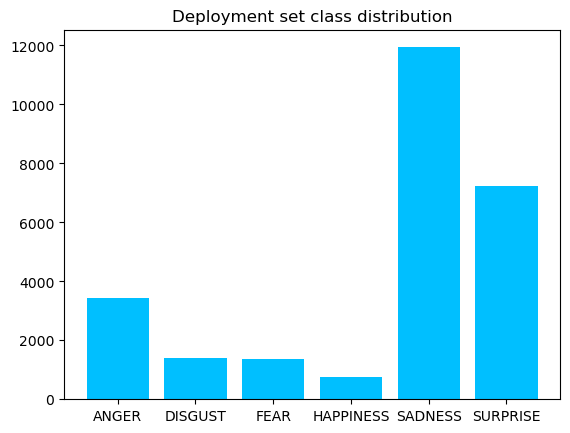

In [40]:
class_distribution2 = Counter(original_label_set2)
print("Deployment set class distribution = ", class_distribution2)
plt.bar(class_distribution2.keys(), class_distribution2.values(), align='center', color='deepskyblue')

plt.title("Deployment set class distribution")

In [41]:
#For production dataset
#Balancing ANGER class set

b = [i for i, x in enumerate(label_encoded_label_set2) if x == 0]
print(len(b))
c = 750
np.random.seed(0)
aug_img_indexes = np.random.choice(b,c)
aug_img_indexes

anger_final_test = []
for i in aug_img_indexes:
    anger_final_test.append(data_set2[i])
    
anger_augmented_labels = np.zeros(len(anger_final_test))
print("Anger final testing images amount = ",len(anger_final_test))

3426
Anger final testing images amount =  750


In [42]:
#For production dataset
#Balancing DISGUST class set

b = [i for i, x in enumerate(label_encoded_label_set2) if x == 1]
print(len(b))
c = 750
np.random.seed(0)
aug_img_indexes = np.random.choice(b,c)
aug_img_indexes

disgust_final_test = []
for i in aug_img_indexes:
    disgust_final_test.append(data_set2[i])
    
disgust_augmented_labels = np.ones(len(disgust_final_test))
print("Disgust final testing images amount = ",len(disgust_final_test))

1394
Disgust final testing images amount =  750


In [43]:
#For production dataset
#Balancing FEAR class set

b = [i for i, x in enumerate(label_encoded_label_set2) if x == 2]
print(len(b))
c = 750
np.random.seed(0)
aug_img_indexes = np.random.choice(b,c)
aug_img_indexes

fear_final_test = []
for i in aug_img_indexes:
    fear_final_test.append(data_set2[i])
    
fear_augmented_labels = np.ones(len(fear_final_test))*2
print("Fear final testing images amount = ",len(disgust_final_test))

1352
Fear final testing images amount =  750


In [44]:
#For production dataset
#Balancing HAPPINESS class set

b = [i for i, x in enumerate(label_encoded_label_set2) if x == 3]
print(len(b))
c = 750
np.random.seed(0)
aug_img_indexes = np.random.choice(b,c)
aug_img_indexes

happiness_final_test = []
for i in aug_img_indexes:
    happiness_final_test.append(data_set2[i])
    
happiness_augmented_labels = np.ones(len(happiness_final_test))*3
print("Happiness final testing images amount = ",len(happiness_final_test))

758
Happiness final testing images amount =  750


In [45]:
#For production dataset
#Balancing SADNESSS class set

b = [i for i, x in enumerate(label_encoded_label_set2) if x == 4]
print(len(b))
c = 750
np.random.seed(0)
aug_img_indexes = np.random.choice(b,c)
aug_img_indexes

sadness_final_test = []
for i in aug_img_indexes:
    sadness_final_test.append(data_set2[i])
    
sadness_augmented_labels = np.ones(len(fear_final_test))*4
print("Sadness final testing images amount = ",len(sadness_final_test))

11939
Sadness final testing images amount =  750


In [46]:
#For production dataset
#Balancing SURPRISE class set

b = [i for i, x in enumerate(label_encoded_label_set2) if x == 5]
print(len(b))
c = 750
np.random.seed(0)
aug_img_indexes = np.random.choice(b,c)
aug_img_indexes

surprise_final_test = []
for i in aug_img_indexes:
    surprise_final_test.append(data_set2[i])
    
surprise_augmented_labels = np.ones(len(surprise_final_test))*5
print("Surprise final testing images amount = ",len(surprise_final_test))

7244
Surprise final testing images amount =  750


In [47]:
x_deployment = anger_final_test + disgust_final_test + fear_final_test + happiness_final_test + sadness_final_test + surprise_final_test 

In [48]:
y_deployment = np.concatenate(( anger_augmented_labels, disgust_augmented_labels, fear_augmented_labels, happiness_augmented_labels, sadness_augmented_labels, surprise_augmented_labels )) 

Deployment set class distribution =  Counter({0.0: 750, 1.0: 750, 2.0: 750, 3.0: 750, 4.0: 750, 5.0: 750})


Text(0.5, 1.0, 'New deployment set class distribution')

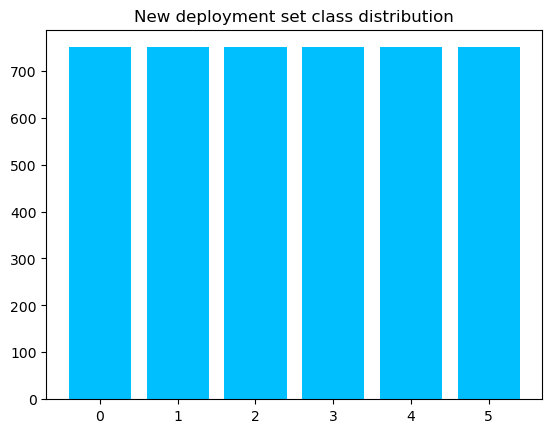

In [49]:
class_distribution2 = Counter(y_deployment)
print("Deployment set class distribution = ", class_distribution2)
plt.bar(class_distribution2.keys(), class_distribution2.values(), align='center', color='deepskyblue')

plt.title("New deployment set class distribution")

In [20]:
%%time
x_deployment_new_aligned, deployment_new_aligned_stat, deployment_new_non_aligned_stat = align_faces(x_deployment, y_deployment)

CPU times: total: 25min 41s
Wall time: 22min 7s


In [ ]:
x_deployment_final = x_deployment_new_aligned
x_deployment_aligned_normalized = normalize_faces(x_deployment_new_aligned)

In [105]:
#deployment dataset without blur is saved
with open('x_deployment.npy', 'wb') as f:
    np.save(f, np.array(x_deployment_aligned_normalized, dtype='float16'))
with open('y_deployment.npy', 'wb') as f:
    np.save(f, y_deployment.astype(int))

In [ ]:
#Generating and saving the low blur level deployment set
b = [i for i, x in enumerate(y_deployment)]
print(len(b))

x_deployment_blur1 = []
for i in b:
    im = Image.fromarray(np.uint8(x_deployment_final[i]))
    blur = im.filter(ImageFilter.BoxBlur(2))
    blurImage = np.array(blur, dtype='uint8')
    x_deployment_blur1.append(blurImage)
    
x_deployment_blur1_normalized = normalize_faces(x_deployment_blur1)

with open('x_deployment_blur1.npy', 'wb') as f:
    np.save(f, np.array(x_deployment_blur1_normalized, dtype='float16'))
with open('y_deployment_blur1.npy', 'wb') as f:
    np.save(f, y_deployment.astype(int))


In [101]:
#Generating and saving the medium blur level deployment set
b = [i for i, x in enumerate(y_deployment)]
print(len(b))

x_deployment_blur2 = []
for i in b:
    im = Image.fromarray(np.uint8(x_deployment_final[i]))
    blur = im.filter(ImageFilter.BoxBlur(4))
    blurImage = np.array(blur, dtype='uint8')
    x_deployment_blur2.append(blurImage)
    
x_deployment_blur2_normalized = normalize_faces(x_deployment_blur2)

with open('x_deployment_blur2.npy', 'wb') as f:
    np.save(f, np.array(x_deployment_blur2_normalized, dtype='float16'))
with open('y_deployment_blur2.npy', 'wb') as f:
    np.save(f, y_deployment.astype(int))


4500


In [100]:
#Generating and saving the high blur level deployment set
b = [i for i, x in enumerate(y_deployment)]
print(len(b))

x_deployment_blur3 = []
for i in b:
    im = Image.fromarray(np.uint8(x_deployment_final[i]))
    blur = im.filter(ImageFilter.BoxBlur(8))
    blurImage = np.array(blur, dtype='uint8')
    x_deployment_blur3.append(blurImage)
    
x_deployment_blur3_normalized = normalize_faces(x_deployment_blur3)

with open('x_deployment_blur3.npy', 'wb') as f:
    np.save(f, np.array(x_deployment_blur3_normalized, dtype='float16'))
with open('y_deployment_blur3.npy', 'wb') as f:
    np.save(f, y_deployment.astype(int))


4500


In [61]:
#Generating and saving the very high blur level deployment set
b = [i for i, x in enumerate(y_deployment)]
print(len(b))

x_deployment_blur4 = []
for i in b:
    im = Image.fromarray(np.uint8(x_deployment_final[i]))
    blur = im.filter(ImageFilter.BoxBlur(14))
    blurImage = np.array(blur, dtype='uint8')
    x_deployment_blur4.append(blurImage)
    
x_deployment_blur4_normalized = normalize_faces(x_deployment_blur4)

with open('x_deployment_blur444.npy', 'wb') as f:
    np.save(f, np.array(x_deployment_blur4_normalized, dtype='float16'))
with open('y_deployment_blur444.npy', 'wb') as f:
    np.save(f, y_deployment.astype(int))


4500


In [50]:
#Examples of the levels of blur of this study
im = Image.fromarray(np.uint8(x_deployment_final[0]))
blurImage1 = im.filter(ImageFilter.BoxBlur(2))
blurImage2 = im.filter(ImageFilter.BoxBlur(4))
blurImage3 = im.filter(ImageFilter.BoxBlur(8))
blurImage4 = im.filter(ImageFilter.BoxBlur(14))

im.save("blur0.jpg")
blurImage1.save("blur1.jpg")
blurImage2.save("blur2.jpg")
blurImage3.save("blur3.jpg")
blurImage4.save("blur4.jpg")

NameError: name 'x_deployment_final' is not defined

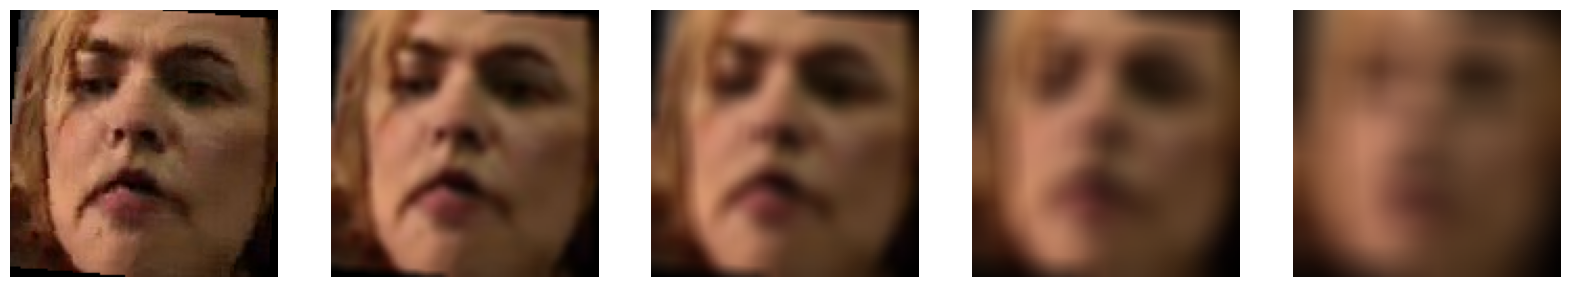

In [60]:
images = []
images.append(im)
images.append(blurImage1)
images.append(blurImage2)
images.append(blurImage3)
images.append(blurImage4)

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(int(len(images) / columns + 1), int(columns), int(i + 1))
    plt.axis('off')
    plt.imshow(image)